# Target Drug Administration Prediction 30 Days in Advance

### Importing Necessary Libraries and Packages:

In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import pandas as pd

### Reading the data, Understanding the basics of data and Addressing basic inconsistencies if any:

In [2]:
df = pd.read_parquet('/kaggle/input/structured-data-2/train.parquet')
df.head()

,Patient-Uid,Date,Incident
0,a0db1e73-1c7c-11ec-ae39-16262ee38c7f,2019-03-09,PRIMARY_DIAGNOSIS
1,a0dc93f2-1c7c-11ec-9cd2-16262ee38c7f,2015-05-16,PRIMARY_DIAGNOSIS
3,a0dc94c6-1c7c-11ec-a3a0-16262ee38c7f,2018-01-30,SYMPTOM_TYPE_0
4,a0dc950b-1c7c-11ec-b6ec-16262ee38c7f,2015-04-22,DRUG_TYPE_0
8,a0dc9543-1c7c-11ec-bb63-16262ee38c7f,2016-06-18,DRUG_TYPE_1


In [3]:
df.shape

(3220868, 3)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3220868 entries, 0 to 29080911
Data columns (total 3 columns):
 #   Column       Dtype         
---  ------       -----         
 0   Patient-Uid  object        
 1   Date         datetime64[ns]
 2   Incident     object        
dtypes: datetime64[ns](1), object(2)
memory usage: 98.3+ MB


##### Checking for duplications and addressing if any:

In [5]:
df.duplicated().sum()

35571

In [6]:
df.index.duplicated().sum()

166693

In [7]:
df.drop_duplicates(inplace = True)
df.reset_index(drop = True, inplace = True)
df.shape

(3185297, 3)

##### Checking for null values:

In [8]:
df.isnull().sum()

Patient-Uid    0
Date           0
Incident       0
dtype: int64

##### Trying to make some basic inferences:

In [9]:
df.describe()

,Patient-Uid,Date,Incident
count,3185297,3185297,3185297
unique,27033,1977,57
top,a0ddfd2c-1c7c-11ec-876d-16262ee38c7f,2019-05-21 00:00:00,DRUG_TYPE_6
freq,1645,3645,549616
first,NaN,2015-04-07 00:00:00,NaN
last,NaN,2020-09-03 00:00:00,NaN


### Inferences derived from the above description of data:

- 27033 unique patients and 57 different types of incidents recorded, out of close to 32 Million records in the train set. Also we can notice that out of close to 5 and half years, almost everyday, some incident seem to have happened with one or other patient... So, there won't be much breaks in between.

- The patient with patient_id - `a0ddfd2c-1c7c-11ec-876d-16262ee38c7f` involved in most number of incidents - 1645.

- Administration of `DRUG_TYPE_6` is the most frequent incident(549616).

- The incidents recorded are between `2015-04-07` and `2020-09-03` which spans over a period of more than 5 years.

### Going Forward...

As the problem statement asks to predict whether patient would take Target Drug or not 30 days in advance, we would leave out all treatments or tests or symptoms that has happened 30 days prior to the first date of target drug administration...

Steps we are going to follow below:

1. Pull out positive set out of df as df is too big to handle.

2. Initialize new column with `NaT(Not a Time - similar to NaN)` named `first_target_date` which will store the date when target drug was administered for the first time.

3. Groupby patient-uid and loop through the data and get the first date of target drug administration and assign it to respective patient-uid on all instances.

4. Right some condition to leave out any incident if it falls in between those 30 days time period.

5. Now that everything we wanted is done, we will drop that column we added earlier so that we can merge it back with df without any errors.

6. Remove already existing positive set in df and concatenate the filtered positive set to df and store it in same variable named df.

Thats all we are gonna do below...

In [10]:
positive_set = df[df['Patient-Uid'].isin(df[df['Incident'] == 'TARGET DRUG']['Patient-Uid'])]

positive_set['first_target_date'] = pd.NaT

for patient_uid, patient_data in positive_set.groupby('Patient-Uid'):
    target_date = patient_data[patient_data['Incident'] == 'TARGET DRUG']['Date'].min()
    positive_set.loc[positive_set['Patient-Uid'] == patient_uid, 'first_target_date'] = target_date

filtered_positive_set = positive_set[~((positive_set['Date'] >= positive_set['first_target_date'] - pd.Timedelta(days=30)) &
                                      (positive_set['Date'] < positive_set['first_target_date']))]

filtered_positive_set.drop(columns='first_target_date', inplace=True)

positive_set_uids = filtered_positive_set['Patient-Uid'].unique()

df = df[~df['Patient-Uid'].isin(positive_set_uids)]

df = pd.concat([df, filtered_positive_set])

df.reset_index(drop=True, inplace=True)

# Saving this as file as this is taking too long to load for every session

df.to_parquet('modified_df.parquet', index = False)

In [11]:
df.shape

(3155125, 3)

### Some feature engineering to extract frequency based features out of the dataframe that we have...

In [12]:
def create_frequency_features(df):
    incident_counts = df.groupby(['Patient-Uid', 'Incident']).size().unstack(fill_value=0)
    incident_counts.columns = [f'{col}_freq' for col in incident_counts.columns]
    incident_counts.columns = [col.replace(' ', '_').lower() for col in incident_counts.columns]
    incident_counts.reset_index(drop = True, inplace = True)    # Here drop - drops the additional column formed out of original index
    return incident_counts

In [13]:
incident_freq_df = create_frequency_features(df)
print(incident_freq_df.shape)
incident_freq_df.head()

(27033, 57)


,drug_type_0_freq,drug_type_1_freq,drug_type_10_freq,drug_type_11_freq,drug_type_12_freq,drug_type_13_freq,drug_type_14_freq,drug_type_15_freq,drug_type_16_freq,drug_type_17_freq,...,symptom_type_7_freq,symptom_type_8_freq,symptom_type_9_freq,target_drug_freq,test_type_0_freq,test_type_1_freq,test_type_2_freq,test_type_3_freq,test_type_4_freq,test_type_5_freq
0,29,0,0,1,0,0,0,0,0,0,...,1,0,0,0,10,2,0,0,0,0
1,8,27,0,0,0,0,0,0,0,0,...,0,0,0,0,1,4,0,0,0,0
2,6,7,0,10,0,0,0,0,0,0,...,0,0,0,0,3,2,0,0,0,0
3,15,42,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,45,0,24,0,0,0,0,0,0,...,5,6,0,0,9,27,1,0,0,0


If person took target drug, irrespective of frequency we are going to make it 1 and if haven't taken we would put 0.

In [14]:
incident_freq_df['target_drug_freq'] = incident_freq_df['target_drug_freq'].apply(lambda x: 1 if x >= 1 else 0)

### Checking whether scaling needed...

In [15]:
def get_column_ranges(df):
    ranges = {}
    for column in df.columns:
        column_min = df[column].min()
        column_max = df[column].max()
        column_range = column_max - column_min
        ranges[column] = [column_min, column_max, column_range]
    return ranges

In [16]:
ranges = get_column_ranges(incident_freq_df)

for column, values in ranges.items():
    print(f"Column: {column}")
    print(f"Minimum: {values[0]}, Maximum: {values[1]}, Range: {values[2]}")
    print()

Column: drug_type_0_freq
Minimum: 0, Maximum: 186, Range: 186

Column: drug_type_1_freq
Minimum: 0, Maximum: 134, Range: 134

Column: drug_type_10_freq
Minimum: 0, Maximum: 72, Range: 72

Column: drug_type_11_freq
Minimum: 0, Maximum: 92, Range: 92

Column: drug_type_12_freq
Minimum: 0, Maximum: 137, Range: 137

Column: drug_type_13_freq
Minimum: 0, Maximum: 70, Range: 70

Column: drug_type_14_freq
Minimum: 0, Maximum: 253, Range: 253

Column: drug_type_15_freq
Minimum: 0, Maximum: 52, Range: 52

Column: drug_type_16_freq
Minimum: 0, Maximum: 57, Range: 57

Column: drug_type_17_freq
Minimum: 0, Maximum: 17, Range: 17

Column: drug_type_18_freq
Minimum: 0, Maximum: 1, Range: 1

Column: drug_type_2_freq
Minimum: 0, Maximum: 153, Range: 153

Column: drug_type_3_freq
Minimum: 0, Maximum: 173, Range: 173

Column: drug_type_4_freq
Minimum: 0, Maximum: 33, Range: 33

Column: drug_type_5_freq
Minimum: 0, Maximum: 88, Range: 88

Column: drug_type_6_freq
Minimum: 0, Maximum: 170, Range: 170

Col

There are variations in range across columns... If we want to use distance based or gradient descent based algorithms, its better to scale them down to somewhat similar range... Let's split the data and then scale and try to compare the performance of multiple models and choose one among them and probably fine tune it to get the desired output...

### X, y split and Training, Validation split:

In [17]:
X = incident_freq_df.drop(columns=['target_drug_freq'])
y = incident_freq_df['target_drug_freq']

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

In [19]:
# Convert all values in X_train and X_val to float
X_train = X_train.astype(float)
X_val = X_val.astype(float)

# Convert all values in y_train and y_val to float
y_train = y_train.astype(float)
y_val = y_val.astype(float)

### Scaling the data:

In [20]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

### Checking for class imbalance and addressing if any...

<Axes: title={'center': 'Imbalance Check Over Target Variable'}>

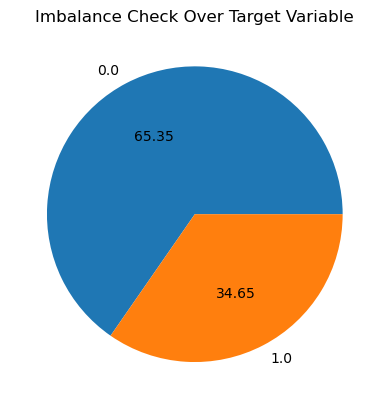

In [21]:
y_train.value_counts().plot.pie(autopct = '%.2f', label = '', title = 'Imbalance Check Over Target Variable')

Let's compare how different imbalance addressing techniques are performing with some important models and pick one out of it to address the imbalance.

In [23]:
important_models = [LogisticRegression(), RandomForestClassifier(), KNeighborsClassifier()]

imbalance_techniques = [('Undersampling', RandomUnderSampler()), ('Oversampling', RandomOverSampler()), ('SMOTE', SMOTE())]

results_df = pd.DataFrame(columns=['Model', 'Imbalance Technique', 'Accuracy', 'F1-Score', 'Overfitting (%)'])

for imbalance_name, imbalance_technique in imbalance_techniques:

    X_train_resampled, y_train_resampled = imbalance_technique.fit_resample(X_train_scaled, y_train)

    for model in important_models:

        model.fit(X_train_resampled, y_train_resampled)
        
        y_train_pred = model.predict(X_train_resampled)
        y_pred = model.predict(X_val_scaled)

        accuracy = accuracy_score(y_val, y_pred)
        f1_val = f1_score(y_val, y_pred, average='weighted')
        
        f1_train = f1_score(y_train_resampled, y_train_pred, average='weighted')

        difference = ((f1_train - f1_val) * 100) / f1_train

        results_df = results_df.append({
            'Model': model.__class__.__name__,
            'Imbalance Technique': imbalance_name,
            'Accuracy': accuracy,
            'F1-Score': f1,
            'Overfitting (%)': difference
        }, ignore_index=True)

results_df

,Model,Imbalance Technique,Accuracy,F1-Score,Overfitting (%)
0,LogisticRegression,Undersampling,0.762530,0.765048,-0.859020
1,RandomForestClassifier,Undersampling,0.788792,0.765048,20.766567
2,KNeighborsClassifier,Undersampling,0.713704,0.765048,10.526894
3,LogisticRegression,Oversampling,0.767339,0.765048,-1.360465
4,RandomForestClassifier,Oversampling,0.801554,0.765048,19.899235
5,KNeighborsClassifier,Oversampling,0.705197,0.765048,15.636287
6,LogisticRegression,SMOTE,0.765489,0.765048,-0.814826
7,RandomForestClassifier,SMOTE,0.800999,0.765048,19.935132
8,KNeighborsClassifier,SMOTE,0.705567,0.765048,16.756776


Both Oversampler and SMOTE seems to be performing comparitively equal... Let's go with Oversampler here as it wouldn't manipulate values on it own using some sythetic computation...

In [24]:
over_sampler = RandomOverSampler()

X_train_res, y_train_res = over_sampler.fit_resample(X_train_scaled, y_train)

<Axes: title={'center': 'Imbalance Check Over Target Variable'}>

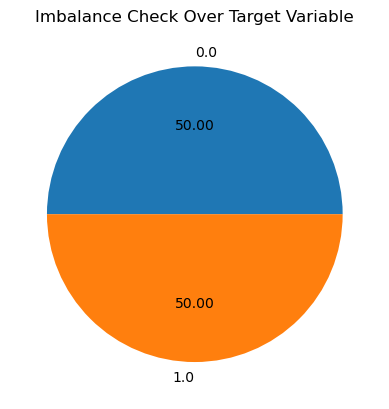

In [25]:
y_train_res.value_counts().plot.pie(autopct = '%.2f', label = '', title = 'Imbalance Check Over Target Variable')

### Trying out different model's performance to pick best performing...

In [26]:
classification_models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier(),
    SVC(),
    KNeighborsClassifier()
]

cls_results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'F1-Score', 'Overfitting (%)'])

for model in classification_models:

    model.fit(X_train_res, y_train_res)
    
    y_train_pred = model.predict(X_train_res)
    y_val_pred = model.predict(X_val_scaled)
    
    accuracy_val = accuracy_score(y_val, y_val_pred)
    f1_val = f1_score(y_val, y_val_pred, average='weighted')
    
    f1_train = f1_score(y_train_res, y_train_pred, average='weighted')

    difference = ((f1_train - f1_val) * 100) / f1_train
    
    cls_results_df = cls_results_df.append({
                           'Model': model.__class__.__name__,
                           'Accuracy': accuracy_val,
                           'F1-Score': f1_val,
                           'Overfitting (%)': difference
                          }, ignore_index=True)

cls_results_df.sort_values(by='F1-Score', ascending=False, inplace=True)
cls_results_df

,Model,Accuracy,F1-Score,Overfitting (%)
2,RandomForestClassifier,0.801923,0.801985,19.801538
4,GradientBoostingClassifier,0.794896,0.798262,1.624979
5,XGBClassifier,0.790457,0.792952,11.484428
3,AdaBoostClassifier,0.782689,0.785597,0.162578
6,SVC,0.771962,0.775457,4.996666
0,LogisticRegression,0.763455,0.765196,-0.866186
1,DecisionTreeClassifier,0.721657,0.721913,27.808684
7,KNeighborsClassifier,0.702608,0.707069,16.107908


Let's go with Gradient Boosting Algorithm which is performing comparitively equally better as well as overfitting less and then after that let's do hp tuning to improve the model further...

In [27]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.001],
    'max_depth': [3, 4, 5],
    'min_samples_leaf': [1, 3, 5],
    'n_estimators': [50, 200, 250, 350]
}

gb_classifier = GradientBoostingClassifier(random_state=42)

grid_search = GridSearchCV(estimator=gb_classifier, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_res, y_train_res)

print("Best Parameters: ", grid_search.best_params_)
print("Best Score (F1): ", grid_search.best_score_)

Best Parameters:  {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 350}
Best Score (F1):  0.828204933749829


### Model Building:

In [30]:
best_params = grid_search.best_params_

cls_model = GradientBoostingClassifier(random_state=42, **best_params)

cls_model.fit(X_train_res, y_train_res)

y_train_pred = model.predict(X_train_res)
y_val_pred = cls_model.predict(X_val_scaled)

accuracy_val = accuracy_score(y_val, y_val_pred)
f1_val = f1_score(y_val, y_val_pred, average='weighted')

f1_train = f1_score(y_train_res, y_train_pred, average='weighted')
difference = ((f1_train - f1_val) * 100) / f1_train

print(f"Accuracy: {accuracy_val}")
print(f"F1-Score: {f1_val}")
print(f"Overfitting (%): {difference:.2f}%")

Accuracy: 0.8019234325873867
F1-Score: 0.8047715455795363
Overfitting (%): 4.52%


We have done as much as we can to improve the model and we got around 0.80 as F1-score and comparitively less overfitting...

**What I did hindsight?**

- I tried with PCA in a different notebook with same preprocessing steps, but couldn't improve it any better...

- I tried with ANN with best and most used loss function, activation function and all and have tried to tune it with keras tuner to get better performance, but it performed poor than top 3 models that we have seen here...

- So, that's when I stuck to the Gradient Booster which wasn't so overfitting and performed comparitively better...


Now, let's move on and work with test set to make submission...

### Reading test set and addressing basic inconsistencies if any...

In [31]:
test_df = pd.read_parquet('/kaggle/input/structured-data-2/test.parquet')
test_df.head()

,Patient-Uid,Date,Incident
0,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2016-12-08,SYMPTOM_TYPE_0
1,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2018-10-17,DRUG_TYPE_0
2,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2017-12-01,DRUG_TYPE_2
3,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2018-12-05,DRUG_TYPE_1
4,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2017-11-04,SYMPTOM_TYPE_0


In [32]:
test_df.shape

(1065524, 3)

In [33]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1065524 entries, 0 to 1372859
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Patient-Uid  1065524 non-null  object        
 1   Date         1065524 non-null  datetime64[ns]
 2   Incident     1065524 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 32.5+ MB


In [34]:
test_df.duplicated().sum()

12100

In [35]:
test_df.index.duplicated().sum()

0

In [36]:
test_df.drop_duplicates(inplace = True)
test_df.shape

(1053424, 3)

In [37]:
test_df.isnull().sum()

Patient-Uid    0
Date           0
Incident       0
dtype: int64

In [38]:
test_df.describe()

,Patient-Uid,Date,Incident
count,1053424,1053424,1053424
unique,11482,1947,55
top,a0faa6ed-1c7c-11ec-8f6f-16262ee38c7f,2018-03-13 00:00:00,DRUG_TYPE_6
freq,1211,1128,188401
first,NaN,2015-04-07 00:00:00,NaN
last,NaN,2020-08-04 00:00:00,NaN


### Inferences derived from the above description of data:

- 11482 unique patients and 55 different types of incidents recorded, out of close to 10.5 Million records in the test set. Also we can notice that out of close to 5 and half years, almost everyday, some incident seem to have happened with one or other patient, although some 50 days less than in train set... So, there won't be much breaks in between obviously here as well.

- There are only 55 unique values in Incident column whereas our train set had 56 excluding Target Drug... There's some incident completely missing in test set, which we need to fill in with 0s or else model will throw error as one of the feature we trained it with is missing...

- The patient with patient_id - `a0faa6ed-1c7c-11ec-8f6f-16262ee38c7f` involved in most number of incidents - 1211.

- Administration of `DRUG_TYPE_6` is the most frequent incident here as well(188401).

- The incidents recorded are between `2015-04-07` and `2020-08-04` which also spans over a period of more than 5 years like train set.

### Feature Engineering Test set so that to make it match the matrix we used to train the model...

We need same function we used to create features there with train set... But, we resetted index there whereas here we need it.... So, reframing the function based our need...

In [39]:
def create_frequency_features_test(df):
    incident_counts = df.groupby(['Patient-Uid', 'Incident']).size().unstack(fill_value=0)
    incident_counts.columns = [f'{col}_freq' for col in incident_counts.columns]
    incident_counts.columns = [col.replace(' ', '_').lower() for col in incident_counts.columns]
    return incident_counts

In [45]:
incident_freq_test_df = create_frequency_features_test(test_df)
print(incident_freq_test_df.shape)
incident_freq_test_df.head()

(11482, 55)


,drug_type_0_freq,drug_type_1_freq,drug_type_10_freq,drug_type_11_freq,drug_type_12_freq,drug_type_13_freq,drug_type_14_freq,drug_type_15_freq,drug_type_16_freq,drug_type_17_freq,...,symptom_type_6_freq,symptom_type_7_freq,symptom_type_8_freq,symptom_type_9_freq,test_type_0_freq,test_type_1_freq,test_type_2_freq,test_type_3_freq,test_type_4_freq,test_type_5_freq
Patient-Uid,,,,,,,,,,,,,,,,,,,,,
a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,8,3,0,1,0,0,0,0,0,0,...,3,0,0,0,2,0,0,0,0,0
a0f9e9f9-1c7c-11ec-b565-16262ee38c7f,2,30,0,0,0,0,0,9,0,0,...,2,0,0,0,0,0,0,1,0,0
a0f9ea43-1c7c-11ec-aa10-16262ee38c7f,4,33,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
a0f9ea7c-1c7c-11ec-af15-16262ee38c7f,2,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
a0f9eab1-1c7c-11ec-a732-16262ee38c7f,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


As we mentioned in the inference above, we need to find which column is missing out and fill it with 0s.

In [46]:
missing_cols = set(incident_freq_df.columns) - set(incident_freq_test_df.columns)
missing_cols

{'drug_type_18_freq', 'target_drug_freq'}

So, we found what is missing... `target_drug_freq` we are gonna predict... But we need to add a column named `drug_type_18_freq` so that the model doesn't throw any error... Also, it won't be in the same order as we had while we were training the model if we add a new column... So, the model would throw some error... In order to address this, we need to insert the column in exact location when we had it during training the model...

In [47]:
column_position = X_train.columns.get_loc('drug_type_18_freq')

incident_freq_test_df.insert(column_position, 'drug_type_18_freq', 0)

incident_freq_test_df.shape

(11482, 56)

### Test set prediction part:

In [48]:
X_test = incident_freq_test_df.copy()

In [49]:
X_test_scaled = scaler.transform(X_test)

In [50]:
y_test = cls_model.predict(X_test_scaled)

In [51]:
submission_df = pd.DataFrame({'Patient-Uid': incident_freq_test_df.index,'label': y_test})
submission_df.head()

,Patient-Uid,label
0,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,0.0
1,a0f9e9f9-1c7c-11ec-b565-16262ee38c7f,1.0
2,a0f9ea43-1c7c-11ec-aa10-16262ee38c7f,0.0
3,a0f9ea7c-1c7c-11ec-af15-16262ee38c7f,0.0
4,a0f9eab1-1c7c-11ec-a732-16262ee38c7f,0.0


In [52]:
submission_df.to_csv('final_submission.csv', index = False)

Thank you so much for the time you have spent all through the notebook... Have got a great experience doing this project and learnt few new things... Thanks for the opportunity and irrespective of the outcome, I am grateful to you for providing me an opportunity to work on such a great problem statement...